In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

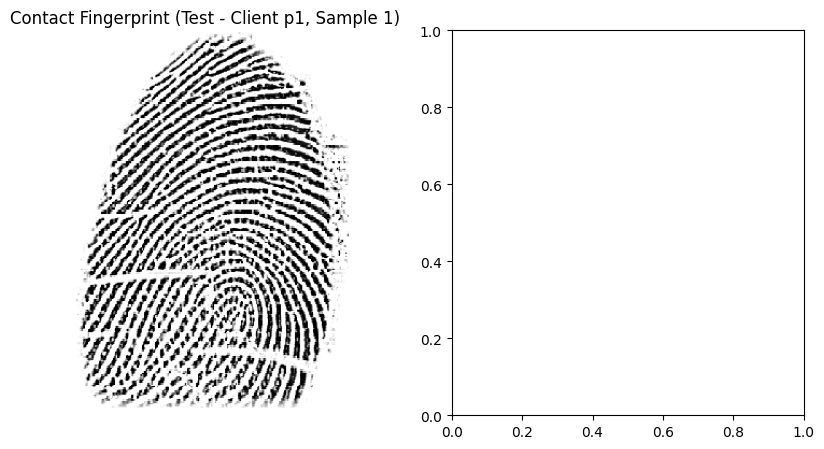

In [39]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define paths to the main data directory and its subdirectories
base_dir = "C:/Users/harsh/Downloads/Cross_Fingerprint_Images_Database"  # Update this path to your actual dataset location
contact_dir = os.path.join(base_dir, 'contact')
contactless_dir = os.path.join(base_dir, 'contactless')

# Load contactless images with subfolders for test/train and clients
def load_contactless_image(set_type, client_id, sample_id):
    client_dir = os.path.join(contactless_dir, set_type, client_id)  # e.g., contactless/test/1
    img_path = os.path.join(client_dir, sample_id+'.bmp')  # Assuming images are BMP
    return Image.open(img_path)

# Load contact images from flat test/train directories
def load_contact_image(set_type, client_num, sample_num):
    img_path = os.path.join(contact_dir, set_type, f'{client_num}_{sample_num}.jpg')  # Assuming images are JPG
    return Image.open(img_path)

# Example usage: Load and display a pair of contact and contactless images for a specific client
set_type = 'test'  # Choose between 'test' or 'train'
client_id = 'p1'  # Example client ID
sample_id='p1'
client_num=1
sample_num = 1  # Example sample number

#contactless_img = load_contactless_image(set_type, client_id, sample_id)
contact_img = load_contact_image(set_type, client_num, sample_num)

# Display images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(contact_img, cmap='gray')
axs[0].set_title(f'Contact Fingerprint ({set_type.capitalize()} - Client {client_id}, Sample {sample_num})')
axs[0].axis('off')
plt.show()


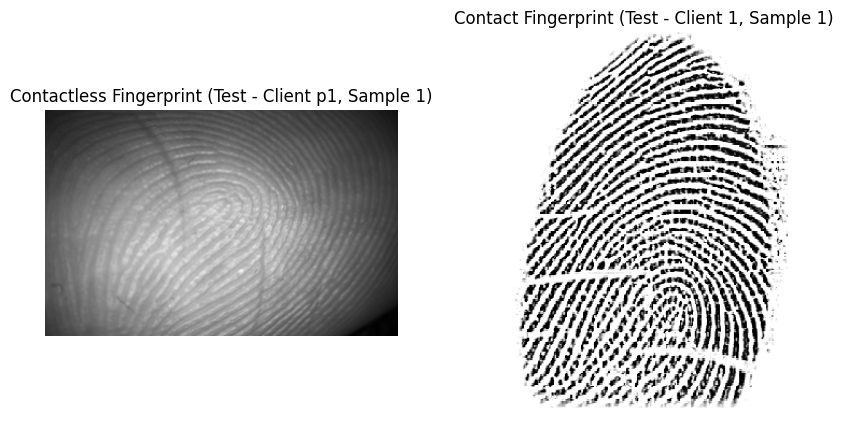

In [40]:
def load_contactless_image(set_type, client_id, sample_id):
    client_dir = os.path.join(contactless_dir, set_type, client_id)  # e.g., contactless/test/1
    img_path = os.path.join(client_dir, sample_id+'.bmp')  # Assuming images are BMP
    return Image.open(img_path)
contactless_img = load_contactless_image(set_type, client_id, sample_id)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(contactless_img, cmap='gray')
axs[0].set_title(f'Contactless Fingerprint ({set_type.capitalize()} - Client {client_id}, Sample {sample_num})')
axs[0].axis('off')

axs[1].imshow(contact_img, cmap='gray')
axs[1].set_title(f'Contact Fingerprint ({set_type.capitalize()} - Client {client_num}, Sample {sample_num})')
axs[1].axis('off')
plt.show()


In [ ]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
  Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


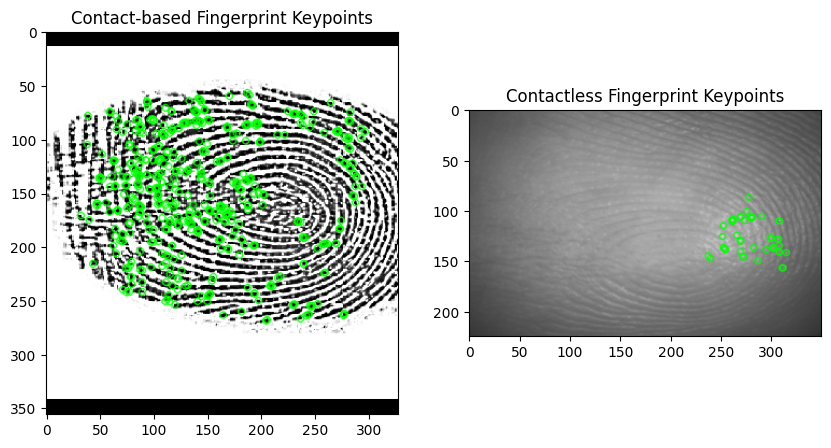

In [42]:
 # Load images
contactless_img = Image.open(contactless_img_path).convert("L")  # Convert contactless image to grayscale
contact_img = Image.open(contact_img_path).rotate(-90)  # Rotate contact image 90 degrees clockwise
        
        # Convert images to grayscale numpy arrays
contactless_img_gray = np.array(contactless_img)  # Already grayscale
contact_img_gray = np.array(contact_img.convert("L"))  # Convert to grayscale after rotation
        
# Use a feature detector (e.g., ORB) for keypoints (replace with minutiae extraction in practice)
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(contact_img_gray, None)
kp2, des2 = orb.detectAndCompute(contactless_img_gray, None)

# Draw keypoints for visualization
img_kp1 = cv2.drawKeypoints(contact_img_gray, kp1, None, color=(0,255,0))
img_kp2 = cv2.drawKeypoints(contactless_img_gray, kp2, None, color=(0,255,0))

# Display keypoints
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(img_kp1, cmap='gray')
plt.title('Contact-based Fingerprint Keypoints')
plt.subplot(1, 2, 2)
plt.imshow(img_kp2, cmap='gray')
plt.title('Contactless Fingerprint Keypoints')
plt.show()


In [44]:
# Convert keypoints to numpy arrays for TPS model
points_contact = np.array([kp.pt for kp in kp1], dtype=np.float32)
points_contactless = np.array([kp.pt for kp in kp2], dtype=np.float32)



In [47]:
points_contact=points_contact[:46]

In [48]:
# Use radial basis function for TPS-style interpolation (e.g., scipy's Rbf)
rbf_x = Rbf(points_contact[:, 0], points_contact[:, 1], points_contactless[:, 0], function='thin_plate')
rbf_y = Rbf(points_contact[:, 0], points_contact[:, 1], points_contactless[:, 1], function='thin_plate')

# Apply transformation to each point
transformed_points_x = rbf_x(points_contact[:, 0], points_contact[:, 1])
transformed_points_y = rbf_y(points_contact[:, 0], points_contact[:, 1])

# New aligned points for contact-based fingerprint
transformed_points = np.vstack((transformed_points_x, transformed_points_y)).T


In [ ]:
# Create a warp matrix based on TPS results
src_points = np.float32(points_contact)
dst_points = np.float32(transformed_points)

# Estimate affine transform from points (for illustration, affine may be generalized)
matrix, _ = cv2.estimateAffinePartial2D(src_points, dst_points)

# Apply warp to correct contact-based fingerprint
warped_contact_img = cv2.warpAffine(contact_img_gray, matrix, (contact_img_gray.shape[1], contact_img_gray.shape[0]))

# Display the corrected contact image
plt.imshow(warped_contact_img, cmap='gray')
plt.title('Deformation Corrected Contact Image')
plt.show()


In [1]:
import os
from PIL import Image
import cv2
import numpy as np
from scipy.interpolate import Rbf

# Define base paths
base_dir = "C:/Users/harsh/Downloads/Cross_Fingerprint_Images_Database"  # Update this to the actual path
contact_train_dir = os.path.join(base_dir, 'contact', 'train')
contactless_train_dir = os.path.join(base_dir, 'contactless', 'train')

# Initialize lists to store all transformation points for DCM training
all_contact_points = []
all_contactless_points = []

# Loop through each client folder in contactless/train
# Loop through each client folder in contactless/train
# Loop through each client folder in contactless/train
# Loop through each client folder in contactless/train
for client_num in range(1, 336):  # Assuming clients are numbered from 1 to 336
    client_folder = f'p{client_num}'
    client_path = os.path.join(contactless_train_dir, client_folder)
    
    # Loop through each of the 6 images
    for img_num in range(1,6):  # Images are named p1, p2, ..., p6
        # Construct file paths
        contactless_img_path = os.path.join(client_path, f'p{img_num}.bmp')  # Assuming .bmp format
        contact_img_path = os.path.join(contact_train_dir, f'{client_num}_{img_num}.jpg')  # Assuming .jpg format
        
        # Load images
        contactless_img = Image.open(contactless_img_path).convert("L")  # Convert contactless image to grayscale
        contact_img = Image.open(contact_img_path).rotate(-90)  # Rotate contact image 90 degrees clockwise
        
        # Convert images to grayscale numpy arrays
        contactless_img_gray = np.array(contactless_img)  # Already grayscale
        contact_img_gray = np.array(contact_img.convert("L"))  # Convert to grayscale after rotation
        
        # Feature extraction (e.g., keypoints for alignment, using ORB here as an example)
        orb = cv2.ORB_create()
        kp_contact, _ = orb.detectAndCompute(contact_img_gray, None)
        kp_contactless, _ = orb.detectAndCompute(contactless_img_gray, None)
    
        # Convert keypoints to numpy arrays
        points_contact = np.array([kp.pt for kp in kp_contact], dtype=np.int16)
        points_contactless = np.array([kp.pt for kp in kp_contactless], dtype=np.int16)
        
        # Check if keypoints are non-empty before appending
        if points_contact.size > 2 and points_contactless.size > 2:
            all_contact_points.append(points_contact)
            all_contactless_points.append(points_contactless)
print(len(all_contact_points),len(all_contactless_points))


1522 1522


In [51]:
max_length = max(len(sublist) for sublist in all_contact_points)

# Pad each sublist with zeros to the maximum length
max_length

500

In [4]:
k=len(all_contactless_points)
k

1522

In [53]:
ct_less=[[]]
for i in range(k-1):
    ct_less.append([])
len(ct_less)


244

In [54]:
ct=[[]]
for i in range(k-1):
    ct.append([])
len(ct)

244

In [55]:
n=500
for i in range(k):
    arr=all_contactless_points[i].tolist()
    m=len(arr)
    l=n-m
    ct_less[i]=arr+[[0,0]]*l

In [56]:
n=500
for i in range(k):
    arr = all_contact_points[i].tolist()
    m=len(arr)
    l=n-m
    ct[i]=arr+[[0,0]]*l

In [57]:
len(ct[k-10])

500

In [5]:
all_contact_points = np.vstack(all_contact_points)
all_contactless_points = np.vstack(all_contactless_points)

In [6]:
all_contactless_points=np.array(all_contactless_points)

In [7]:
all_contact_points=np.array(all_contact_points)

In [14]:
m=all_contactless_points.shape[0]
m

108069

In [15]:
all_contact_points=all_contact_points[:m]

In [16]:
print(all_contactless_points.shape)
print(all_contact_points.shape)

(108069, 2)
(108069, 2)


In [62]:
max_length = max(len(sublist) for sublist in all_contactless_points)

# Pad each sublist with zeros to the maximum length
max_length

2

In [63]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\harsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [17]:
all_contact_points = all_contact_points.astype(np.float32)
all_contactless_points = all_contactless_points.astype(np.float32)

In [18]:
all_contact_points += np.random.normal(0, 1e-10, all_contact_points.shape)
all_contactless_points += np.random.normal(0, 1e-10, all_contactless_points.shape)

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
all_contact_points = scaler.fit_transform(all_contact_points)
all_contactless_points = scaler.fit_transform(all_contactless_points)

In [ ]:
# Downsampling the points (e.g., using 10% of the total points)
sample_size = int(len(all_contact_points) * 0.5)
sampled_contact_points = all_contact_points[:sample_size]
sampled_contactless_points = all_contactless_points[:sample_size]

# Apply RBF interpolation with the downsampled data
rbf_x = Rbf(sampled_contact_points[:, 0], sampled_contact_points[:, 1], sampled_contactless_points[:, 0], function='thin_plate')
rbf_y = Rbf(sampled_contact_points[:, 0], sampled_contact_points[:, 1], sampled_contactless_points[:, 1], function='thin_plate')


In [ ]:
rbf_x = Rbf(all_contact_points[:, 0], all_contact_points[:, 1], all_contactless_points[:, 0], function='thin_plate')
rbf_y = Rbf(all_contact_points[:, 0], all_contact_points[:, 1], all_contactless_points[:, 1], function='thin_plate')

In [ ]:
def apply_deformation_correction(x,y):
    return rbf_x(x, y), rbf_y(x, y)

In [ ]:
def apply_deformation_correction_on_contact_image(contact_img):
    """ Apply deformation correction to a contact-based image. """
    # Convert the contact image to grayscale
    contact_img_gray = np.array(contact_img.convert("L"))
    
    # Feature extraction (e.g., using ORB)
    orb = cv2.ORB_create()
    kp_contact, _ = orb.detectAndCompute(contact_img_gray, None)
    
    # Convert keypoints to numpy arrays
    points_contact = np.array([kp.pt for kp in kp_contact], dtype=np.float32)
    
    # Apply the trained DCM (deformation correction model) to the keypoints of the contact-based image
    corrected_x, corrected_y = apply_deformation_correction(points_contact[:, 0], points_contact[:, 1])
    
    # Visualize the original and corrected keypoints on the contact-based image
    contact_img_with_keypoints = np.array(contact_img)
    
    # Draw original keypoints in red
    for pt in points_contact:
        cv2.circle(contact_img_with_keypoints, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)
    
    # Draw corrected keypoints in green
    for pt_x, pt_y in zip(corrected_x, corrected_y):
        cv2.circle(contact_img_with_keypoints, (int(pt_x), int(pt_y)), 5, (0, 255, 0), -1)
    
    # Convert the images back to PIL for display
    contact_img_with_keypoints = Image.fromarray(contact_img_with_keypoints)
    
    # save the  corrected images
    plt.imsave('C:/Users/harsh/Downloads/corrected_img', contact_img_with_keypoints)

# Example usage: Apply deformation correction on a contact image
contact_img_path = "C:/Users/harsh/Downloads/org_img"  # Update with an actual path
apply_deformation_correction_on_contact_image(contact_img)


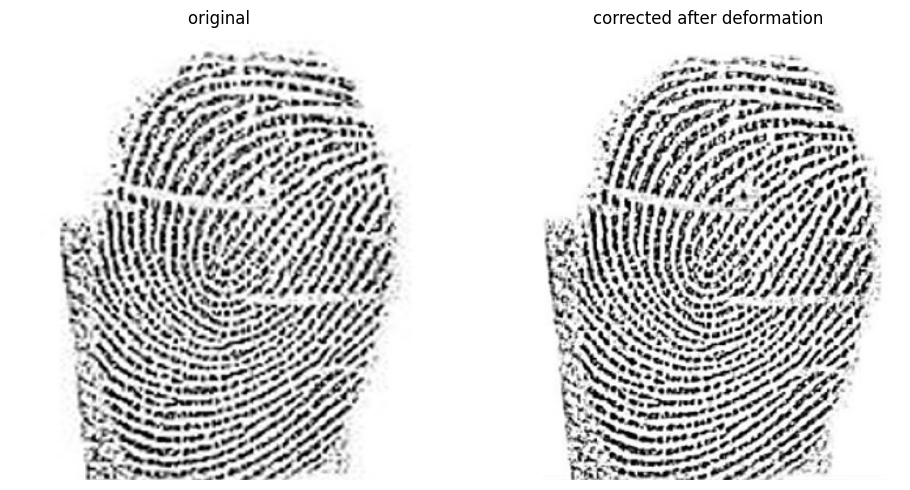

In [25]:
import matplotlib.pyplot as plt
import cv2  # or use any library to read images

# Read the images
image1 = cv2.imread('C:/Users/harsh/Downloads/org_img.jpg')
image2 = cv2.imread('C:/Users/harsh/Downloads/corrected_img.jpg')

# Display the images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1)
axes[0].axis('off')
axes[0].set_title('original ')

axes[1].imshow(image2)
axes[1].axis('off')
axes[1].set_title('corrected after deformation')

plt.tight_layout()
plt.show()